# Gráficas para estudio de reservas en Guatemala

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
reservas = pd.read_excel("db/datos_reservas.xlsx")

In [22]:
reservas

,Mes,2018,2019,2020,2021,2022,2023,2024
0,Enero,23583.6,22534.9,25004.7,28095.1,30942.2,36777.0,39072.4
1,Febrero,23231.1,24279.6,22833.8,29303.8,31668.0,37656.0,39171.0
2,Marzo,23394.5,23921.7,26790.2,31923.8,33728.4,34766.3,NaN
3,Abril,22069.4,23513.2,28703.3,26911.7,30956.3,34766.3,NaN
4,Mayo,22381.8,24414.8,22167.7,30746.3,32612.2,37480.9,NaN
5,Junio,22871.6,24413.0,25497.2,34148.4,36370.1,40189.6,NaN
6,Julio,20389.7,26429.6,25330.4,27826.9,34156.6,37355.8,NaN
7,Agosto,22894.1,24245.4,25994.5,30667.9,33732.9,36738.0,NaN
8,Septiembre,23767.9,24682.2,31699.1,32638.9,34369.5,33770.6,NaN
9,Octubre,23591.0,25821.8,25824.7,28990.0,35388.7,34419.0,NaN


In [ ]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=reservas.melt('Mes', var_name='Año', value_name='Reservas'), x='Mes', y='Reservas', hue='Año', marker='o', palette=["#19315F", "#F48401", "#BDDB05", "#11C876", "#879484", "#BC2EE6", "#621A22"])

plt.xticks(rotation=45)
plt.title('Reservas Bancarias por Año')
plt.xlabel('Mes')
plt.ylabel('Reservas en millones de quetzales')

# Mueve la leyenda fuera del gráfico, a la parte superior derecha
plt.legend(title='Año', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

## Calcular variaciones intermensuales e interanuales

In [44]:
# Variaciones intermensuales
int_mensuales = reservas[[i for i in range(2018, 2024)]].diff().fillna(0)
int_mensuales

,2018,2019,2020,2021,2022,2023
0,0.0,0.0,0.0,0.0,0.0,0.0
1,-352.5,1744.7,-2170.9,1208.7,725.8,879.0
2,163.4,-357.9,3956.4,2620.0,2060.4,-2889.7
3,-1325.1,-408.5,1913.1,-5012.1,-2772.1,0.0
4,312.4,901.6,-6535.6,3834.6,1655.9,2714.6
5,489.8,-1.8,3329.5,3402.1,3757.9,2708.7
6,-2481.9,2016.6,-166.8,-6321.5,-2213.5,-2833.8
7,2504.4,-2184.2,664.1,2841.0,-423.7,-617.8
8,873.8,436.8,5704.6,1971.0,636.6,-2967.4
9,-176.9,1139.6,-5874.4,-3648.9,1019.2,648.4


C:\Users\Mariajose\AppData\Local\Temp\ipykernel_13640\2481080316.py:12: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_long, x='Mes', y='Reservas', hue='Año', marker='o',


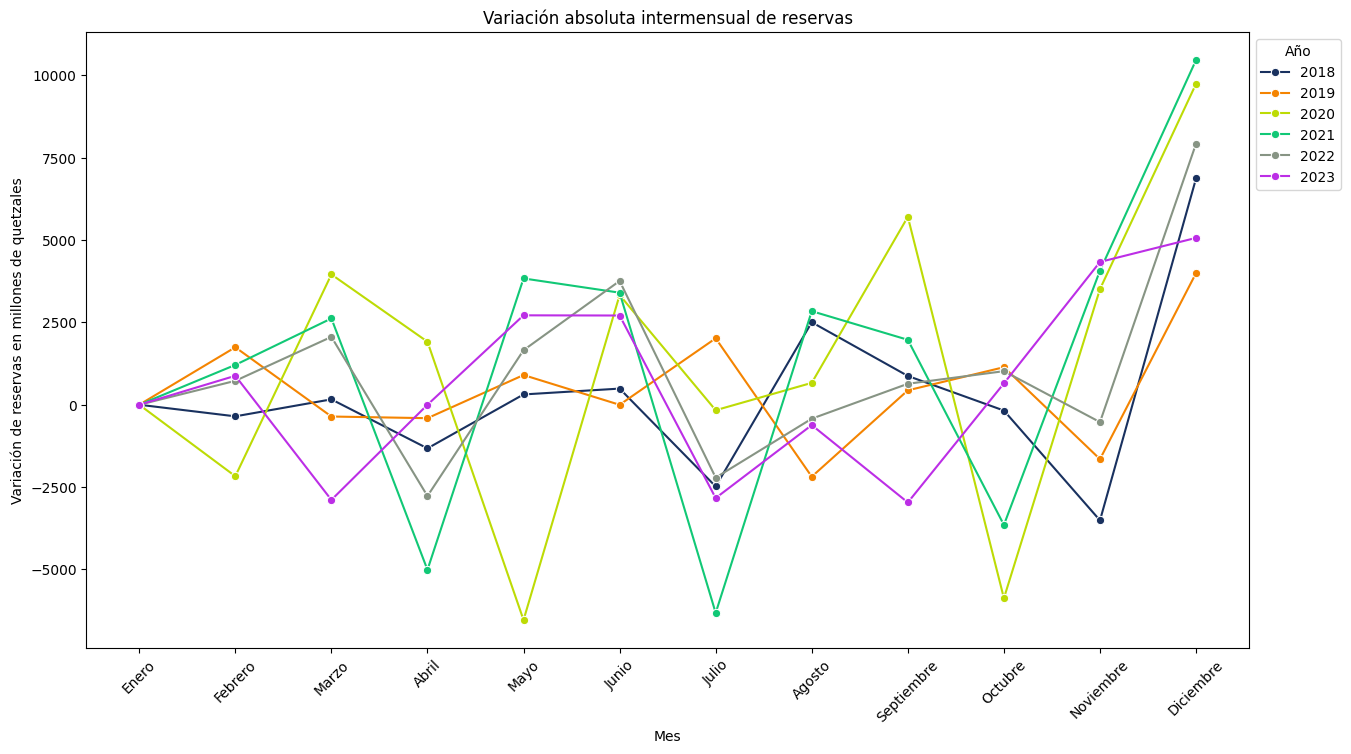

In [39]:
# Reestructurar el DataFrame de formato ancho a largo
df_long = int_mensuales.reset_index().melt(id_vars=['index'], var_name='Año', value_name='Reservas')
df_long = df_long.rename(columns={'index': 'Mes'})

# Crear un mapa que asigne cada número de mes a su nombre, si no tienes los nombres en tu DataFrame
month_map = {0: 'Enero', 1: 'Febrero', 2: 'Marzo', 3: 'Abril', 4: 'Mayo', 5: 'Junio', 
             6: 'Julio', 7: 'Agosto', 8: 'Septiembre', 9: 'Octubre', 10: 'Noviembre', 11: 'Diciembre'}
df_long['Mes'] = df_long['Mes'].map(month_map)

# Ahora graficar usando Seaborn
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_long, x='Mes', y='Reservas', hue='Año', marker='o',
             palette=["#19315F", "#F48401", "#BDDB05", "#11C876", "#879484", "#BC2EE6", "#621A22"])

plt.xticks(rotation=45)
plt.title('Variación absoluta intermensual de reservas')
plt.xlabel('Mes')
plt.ylabel('Variación de reservas en millones de quetzales')

# Mueve la leyenda fuera del gráfico, a la parte superior derecha
plt.legend(title='Año', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [35]:
# Hacer diccionario con estadísticos por año
est_anuales = {i: [0,0,0,0] for i in range(2018,2024)}
for i in range(2018, 2024):
    est_anuales[i][0] = int_mensuales[i].mean()
    est_anuales[i][1] = int_mensuales[i].var()
    est_anuales[i][2] = int_mensuales[i].min()
    est_anuales[i][3] = int_mensuales[i].max()

df_est_anuales = pd.DataFrame.from_dict(est_anuales, orient="index", columns=["Promedio", "Varianza", "Mínimo", "Máximo"])
df_est_anuales.index.name = "Año"

df_est_anuales

,Promedio,Varianza,Mínimo,Máximo
Año,,,,
2018,280.691667,6.733965e+06,-3510.9,6871.8
2019,469.358333,2.776884e+06,-2184.2,3997.6
2020,1172.983333,2.146493e+07,-6535.6,9744.1
2021,1286.125000,2.102225e+07,-6321.5,10467.1
2022,987.183333,7.933907e+06,-2772.1,7927.5
2023,586.900000,7.435334e+06,-2967.4,5066.1
